In [1]:
!pip install Levenshtein

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 54.7 MB/s eta 0:00:00


In [2]:
!pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import os
import tqdm
import json
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Sequential, Conv2d, AvgPool2d, GRU, Linear
from torch.nn.functional import ctc_loss, log_softmax
from torchvision import models

import string

np.random.seed(42)

In [4]:
import cv2

In [5]:
import Levenshtein as lev
from livelossplot import PlotLosses
from torch.nn import CTCLoss as ctc_loss

In [6]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!echo '{"username":"romanzilotov","key":"635cb29cb7d650bc70192229990585dc"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c vk-made-ocr
!unzip vk-made-ocr.zip -d ./

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: ./train/train/9550.jpg  
  inflating: ./train/train/95500.jpg  
  inflating: ./train/train/95501.jpg  
  inflating: ./train/train/95502.jpg  
  inflating: ./train/train/95503.jpg  
  inflating: ./train/train/95504.jpg  
  inflating: ./train/train/95505.jpg  
  inflating: ./train/train/95506.jpg  
  inflating: ./train/train/95507.jpg  
  inflating: ./train/train/95508.jpg  
  inflating: ./train/train/95509.jpg  
  inflating: ./train/train/9551.jpg  
  inflating: ./train/train/95510.jpg  
  inflating: ./train/train/95511.jpg  
  inflating: ./train/train/95512.jpg  
  inflating: ./train/train/95513.jpg  
  inflating: ./train/train/95514.jpg  
  inflating: ./train/train/95515.jpg  
  inflating: ./train/train/95516.jpg  
  inflating: ./train/train/95517.jpg  
  inflating: ./train/train/95518.jpg  
  inflating: ./train/train/95519.jpg  
  inflating: ./train/train/9552.jpg  
  inflating: ./train/train/95520.jpg  

# Датасет

## Посмотрим на данные и на лейблы

In [7]:
PATH_TO_DATA = "./"
TRAIN_LABELS_PATH = 'train_labels.csv'

train_labels_pd = pd.read_csv(PATH_TO_DATA + TRAIN_LABELS_PATH).dropna()
train_labels_pd.head(2)

,Id,Expected
0,1.jpg,Атырау
1,2.jpg,транз


In [8]:
train_labels_pd.shape

(275973, 2)

In [9]:
train_labels = []
for i in range(train_labels_pd.shape[0]):
    train_labels.append({
        'filename': train_labels_pd.iloc[i]['Id'],
        'label': train_labels_pd.iloc[i]['Expected']
    })

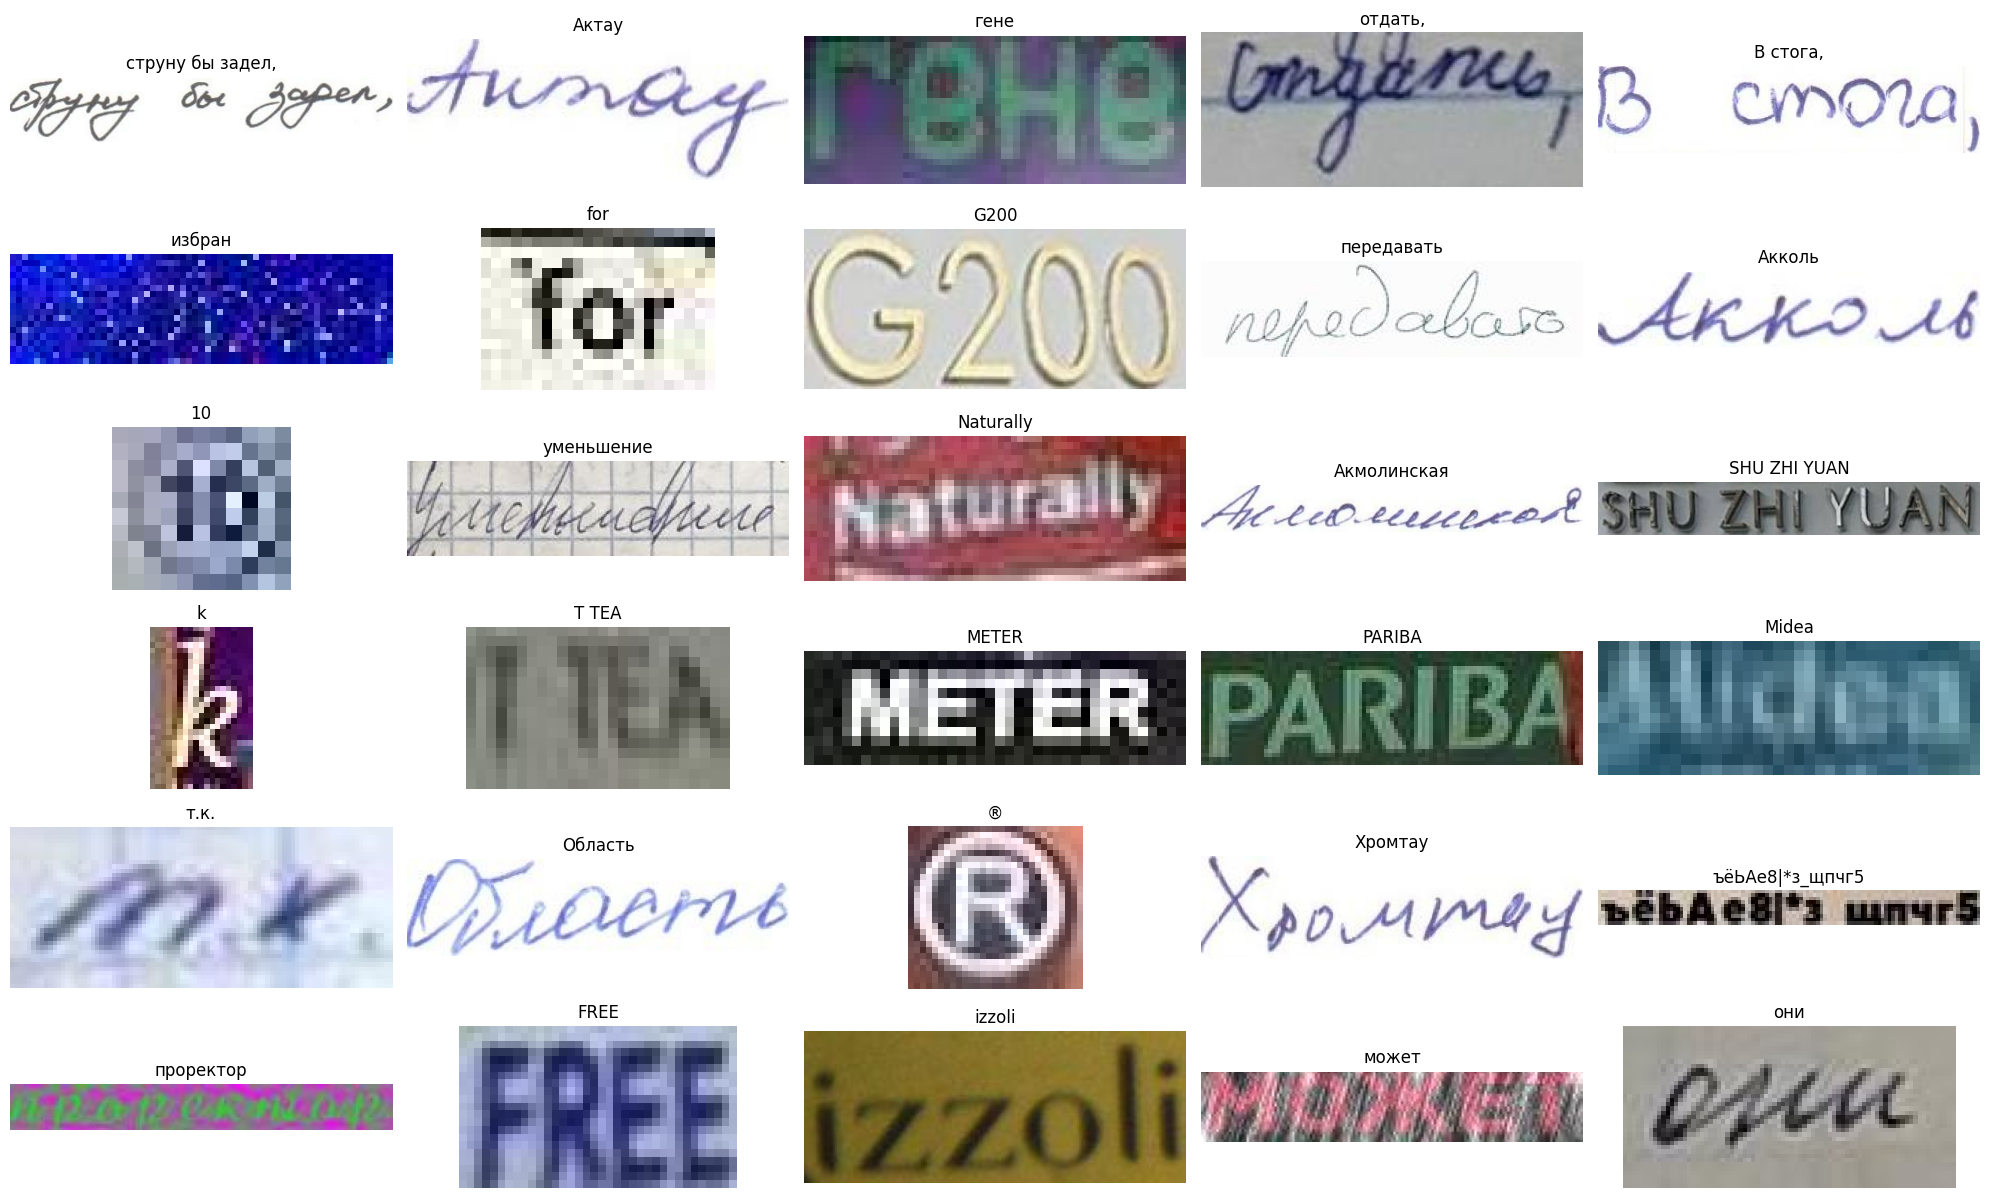

In [10]:
NUM_COLS = 5
NUM_ROWS = 6

random_idxs = np.random.choice(len(train_labels), size=NUM_COLS*NUM_ROWS, replace=False)
plt.figure(figsize=(20, 2 * NUM_ROWS))
for i, idx in enumerate(random_idxs, 1):
    item = train_labels[idx]
    label = item["label"]
    image = cv2.imread(PATH_TO_DATA + 'train/train/' + item["filename"])

    plt.subplot(NUM_ROWS, NUM_COLS, i)
    plt.imshow(image[:, :, ::-1])
    plt.title(label)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Отфильтруем данные с символами не из алфавита

In [11]:
alphabet = ''
alphabet += string.ascii_letters
alphabet += string.digits
alphabet += string.punctuation
alphabet += 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'
alphabet += 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя'.upper()
alphabet += ' '
alphabet

'abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~абвгдеёжзийклмнопрстуфхцчшщъыьэюяАБВГДЕЁЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ '

In [12]:
def check_in_alphabet(text, alphabet=alphabet):
    for char in text:
        if char not in alphabet:
            return False
    return True

assert check_in_alphabet("asd123фыв'[\+") is True
assert check_in_alphabet("§") is False

In [13]:
print('Всего до фильтрации: ', len(train_labels))

Всего до фильтрации:  275973


In [14]:
def filter_data(train_labels):
    filtered = []
    for item in train_labels:
        label = item["label"]
        if check_in_alphabet(label):
            filtered.append({"filename": item["filename"],
                             "label": item["label"]})
    return filtered

In [15]:
train_labels = filter_data(train_labels)
print('Всего после фильтрации: ', len(train_labels))

Всего после фильтрации:  268757


## Зададим класс

In [16]:
class RecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, train_labels, alphabet=alphabet, transforms=None):
        """Constructor for class.

        Args:
            - train_labels: List of items, each of which is a dict with keys "file" & "text".
            - alphabet: String of chars required for predicting.
            - transforms: Transformation for items, should accept and return dict with keys "image", "seq", "seq_len" & "text".
        """
        super(RecognitionDataset, self).__init__()
        self.train_labels = train_labels
        self.alphabet = alphabet
        self.image_names, self.texts = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names, texts = [], []
        for item in self.train_labels:
            image_name = item["filename"]
            text = item['label']
            texts.append(text)
            image_names.append(image_name)
        return image_names, texts

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """

        image = cv2.imread(PATH_TO_DATA + 'train/train/' + self.image_names[item]).astype(np.float32) / 255.
        text = self.texts[item]
        seq = self.text_to_seq(text)
        seq_len = len(seq)
        output = dict(image=image, seq=seq, seq_len=seq_len, text=text)
        if self.transforms is not None:
            output = self.transforms(output)
        return output

    def text_to_seq(self, text):
        """Encode text to sequence of integers.

        Args:
            - String of text.

        Returns:
            List of integers where each number is index of corresponding characted in alphabet + 1.
        """

        # YOUR CODE HERE
        seq = [self.alphabet.find(c) + 1 for c in text]
        # END OF YOUR CODE

        return seq

In [17]:
class Resize(object):

    def __init__(self, size=(320, 64)):
        self.size = size

    def __call__(self, item):
        """Apply resizing.

        Args:
            - item: Dict with keys "image", "seq", "seq_len", "text".

        Returns:
            Dict with image resized to self.size.
        """

        # YOUR CODE HERE
        interpolation = cv2.INTER_AREA if self.size[0] < item["image"].shape[1] else cv2.INTER_LINEAR
        item["image"] = cv2.resize(item["image"], self.size, interpolation=interpolation)
        # END OF YOUR CODE

        return item

In [18]:
transforms = Resize(size=(320, 64))
dataset = RecognitionDataset(train_labels, alphabet=alphabet, transforms=transforms)

In [19]:
x = dataset[0]
print(x.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


Image shape: (64, 320, 3)
Seq: [128, 114, 123, 112, 95, 115] Seq_len: 6
Text: Атырау


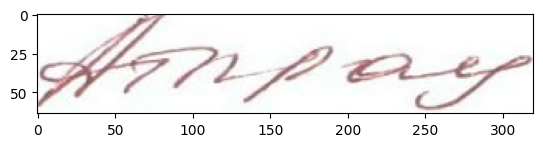

In [20]:
print("Image shape:", x["image"].shape)
print("Seq:", x["seq"], "Seq_len:", x["seq_len"])
print("Text:", x["text"])
plt.imshow(x["image"])
plt.show()

In [21]:
def collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, seqs, seq_lens, texts = [], [], [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        seqs.extend(item["seq"])
        seq_lens.append(item["seq_len"])
        texts.append(item["text"])
    images = torch.stack(images)
    seqs = torch.Tensor(seqs).int()
    seq_lens = torch.Tensor(seq_lens).int()
    batch = {"image": images, "seq": seqs, "seq_len": seq_lens, "text": texts}
    return batch

In [22]:
xs = [dataset[i] for i in range(4)]
batch = collate_fn(xs)
print(batch.keys())

dict_keys(['image', 'seq', 'seq_len', 'text'])


In [23]:
print("Image:", batch["image"].size())
print("Seq:", batch["seq"].size())
print("Seq:", batch["seq"])
print("Seq_len:", batch["seq_len"])
print("Text:", batch["text"])

Image: torch.Size([4, 3, 64, 320])
Seq: torch.Size([25])
Seq: tensor([128, 114, 123, 112,  95, 115, 114, 112,  95, 109, 103, 117, 110,  99,
        127, 114, 110, 121, 115, 121, 100, 109, 104, 105,  74],
       dtype=torch.int32)
Seq_len: tensor([6, 5, 5, 9], dtype=torch.int32)
Text: ['Атырау', 'транз', 'ходят', 'ощущений,']


# Модель

## feature extractor

In [24]:
class FeatureExtractor(Module):

    def __init__(self, input_size=(64, 320), output_len=25):
        super(FeatureExtractor, self).__init__()

        h, w = input_size
        resnet = getattr(models, 'resnet50')(pretrained=True)
        self.cnn = Sequential(*list(resnet.children())[:-2])

        self.pool = AvgPool2d(kernel_size=(h // 32, 1))
        self.proj = Conv2d(w // 32, output_len, kernel_size=1)

        self.num_output_features = self.cnn[-1][-1].bn3.num_features

    def apply_projection(self, x):
        """Use convolution to increase width of a features.

        Args:
            - x: Tensor of features (shaped B x C x H x W).

        Returns:
            New tensor of features (shaped B x C x H x W').
        """
        x = x.permute(0, 3, 2, 1).contiguous()
        x = self.proj(x)
        x = x.permute(0, 2, 3, 1).contiguous()

        return x

    def forward(self, x):
        # Apply conv layers
        features = self.cnn(x)

        # Pool to make height == 1
        features = self.pool(features)

        # Apply projection to increase width
        features = self.apply_projection(features)

        return features

In [25]:
feature_extractor = FeatureExtractor();

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 82.9MB/s]


In [26]:
x = torch.randn(1, 3, 64, 320)
y = feature_extractor(x)
assert y.size() == (1, 1, 2048, 25)

## sequence predictor

In [27]:
class SequencePredictor(Module):

    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.3, bidirectional=False):
        super(SequencePredictor, self).__init__()

        self.num_classes = num_classes
        self.rnn = GRU(input_size=input_size,
                       hidden_size=hidden_size,
                       num_layers=num_layers,
                       dropout=dropout,
                       bidirectional=bidirectional)

        fc_in = hidden_size if not bidirectional else 2 * hidden_size
        self.fc = Linear(in_features=fc_in,
                         out_features=num_classes)

    def _init_hidden(self, batch_size):
        """Initialize new tensor of zeroes for RNN hidden state.

        Args:
            - batch_size: Int size of batch

        Returns:
            Tensor of zeros shaped (num_layers * num_directions, batch, hidden_size).
        """
        num_directions = 2 if self.rnn.bidirectional else 1

        # YOUR CODE HERE
        h = torch.zeros(self.rnn.num_layers * num_directions, batch_size, self.rnn.hidden_size)
        # END OF YOUR CODE

        return h

    def _reshape_features(self, x):
        """Change dimensions of x to fit RNN expected input.

        Args:
            - x: Tensor x shaped (B x (C=1) x H x W).

        Returns:
            New tensor shaped (W x B x H).
        """

        # YOUR CODE HERE
        x = x.squeeze(1)
        x = x.permute(2, 0, 1)
        # END OF YOUR CODE

        return x

    def forward(self, x):
        x = self._reshape_features(x)

        batch_size = x.size(1)
        h_0 = self._init_hidden(batch_size)
        h_0 = h_0.to(x.device)
        x, h = self.rnn(x, h_0)

        x = self.fc(x)
        return x

In [28]:
sequence_predictor = SequencePredictor(input_size=2048,
                                       hidden_size=128,
                                       num_layers=2,
                                       num_classes=len(alphabet) + 1)

In [29]:
x = torch.randn(1, 1, 2048, 25)
assert sequence_predictor._reshape_features(x).size() == (25, 1, 2048)

In [30]:
y = sequence_predictor(x)
assert y.size() == (25, 1, 162)

## Собираем модель

In [31]:
class CRNN(Module):

    def __init__(self, alphabet=alphabet,
                 cnn_input_size=(64, 320), cnn_output_len=25,
                 rnn_hidden_size=128, rnn_num_layers=2, rnn_dropout=0.3, rnn_bidirectional=False):
        super(CRNN, self).__init__()
        self.alphabet = alphabet
        self.features_extractor = FeatureExtractor(input_size=cnn_input_size, output_len=cnn_output_len)
        print(cnn_input_size, cnn_output_len)

        print(self.features_extractor.num_output_features, rnn_num_layers)
        self.sequence_predictor = SequencePredictor(input_size=self.features_extractor.num_output_features,
                                                    hidden_size=rnn_hidden_size, num_layers=rnn_num_layers,
                                                    num_classes=len(alphabet)+1, dropout=rnn_dropout,
                                                    bidirectional=rnn_bidirectional)

    def forward(self, x):
        features = self.features_extractor(x)
        sequence = self.sequence_predictor(features)
        return sequence

In [32]:
def pred_to_string(pred, alphabet):
    seq = []
    for i in range(len(pred)):
        label = np.argmax(pred[i])
        seq.append(label - 1)
    out = []
    for i in range(len(seq)):
        if len(out) == 0:
            if seq[i] != -1:
                out.append(seq[i])
        else:
            if seq[i] != -1 and seq[i] != seq[i - 1]:
                out.append(seq[i])
    out = ''.join([alphabet[c] for c in out])
    return out

def decode(pred, alphabet):
    pred = pred.permute(1, 0, 2).cpu().data.numpy()
    outputs = []
    for i in range(len(pred)):
        outputs.append(pred_to_string(pred[i], alphabet))
    return outputs

In [33]:
crnn = CRNN()

(64, 320) 25
2048 2


In [34]:
x = torch.randn(1, 3, 64, 320)
y = crnn(x)
assert y.size() == (25, 1, 162)

In [35]:
decode(y, alphabet)

['фQ}фШ}Ш=5ШQБ smБ}?A&`']

# Обучение модели

In [36]:
np.random.shuffle(train_labels)
train_size = int(len(train_labels) * 0.8)
config_train = train_labels[:train_size]
config_val = train_labels[train_size:]

train_dataset = RecognitionDataset(config_train, transforms=Resize())
val_dataset = RecognitionDataset(config_val, transforms=Resize())

In [37]:
optimizer = torch.optim.Adam(crnn.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)

In [38]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda:0


In [39]:
model = CRNN()
model.to(device);

(64, 320) 25
2048 2


In [43]:
num_epochs = 3
batch_size = 128
num_workers = 4

In [41]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True,
                              drop_last=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                            drop_last=False, collate_fn=collate_fn)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [42]:
import os
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


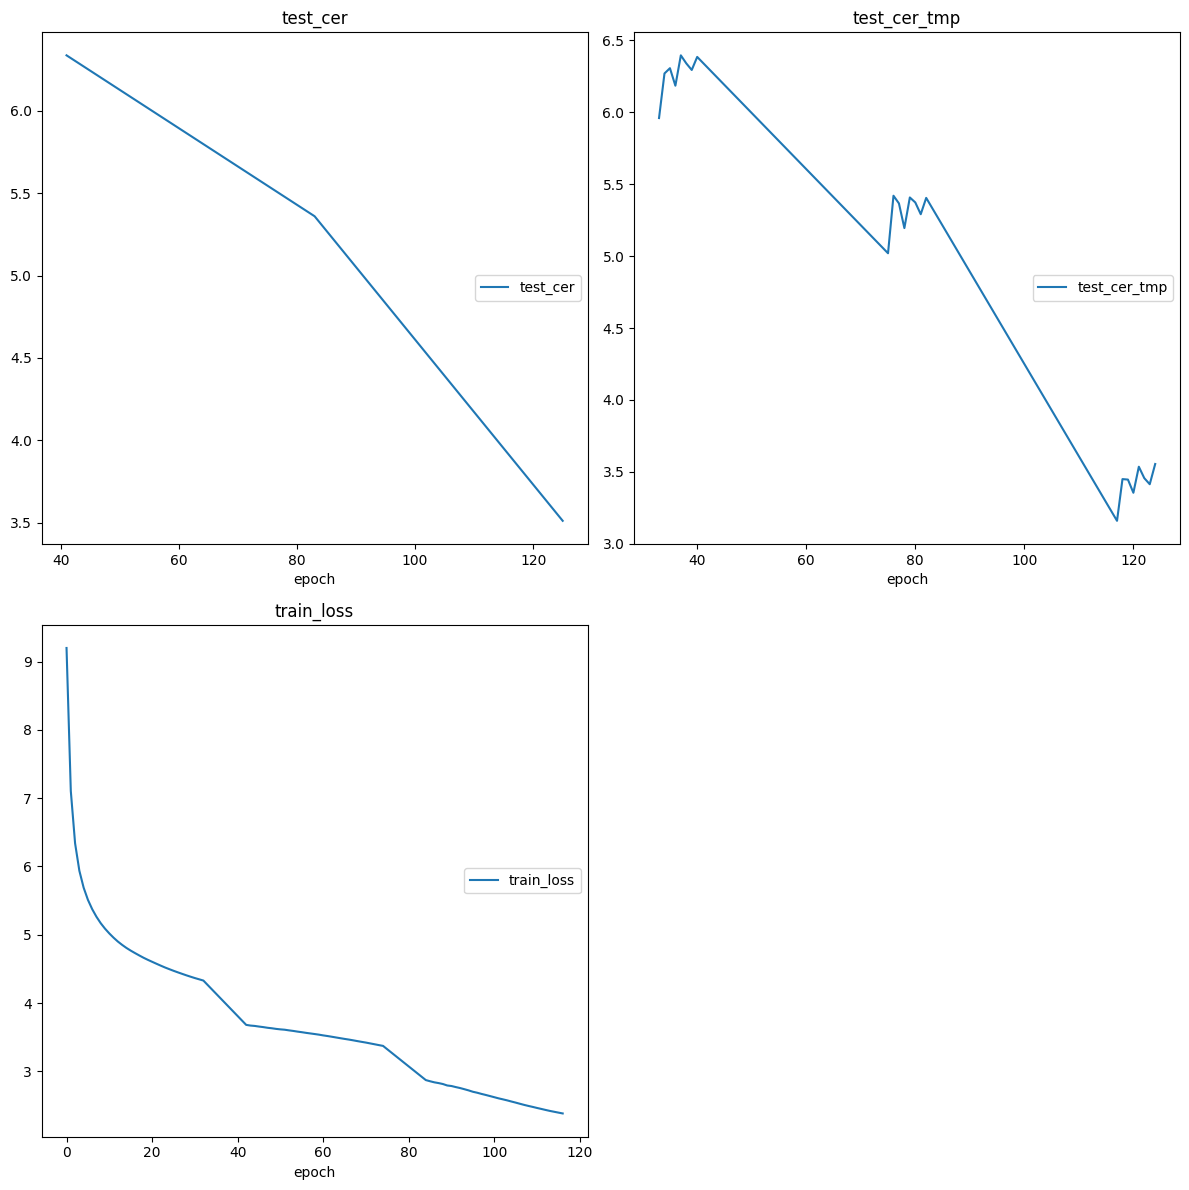

test_cer
	test_cer         	 (min:    3.512, max:    6.336, cur:    3.512)
test_cer_tmp
	test_cer_tmp     	 (min:    3.160, max:    6.396, cur:    3.555)
train_loss
	train_loss       	 (min:    2.386, max:    9.198, cur:    2.386)


In [44]:
criterion = ctc_loss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
plotlosses = PlotLosses()
min_cer = 10.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        input, labels = batch["image"].to(device), batch["seq"].long().to(device)
        preds = model(input).log_softmax(2)
        seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()

        loss = criterion(preds, labels, seq_lens_pred, batch['seq_len'])
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item()

        if idx % 50 == 49:
            mean_loss = running_loss / (idx + 1)
            plotlosses.update({'train_loss': mean_loss})
            plotlosses.send()

    model.eval()
    running_cer = 0.0
    for idx, batch in enumerate(val_dataloader):
        input, text = batch["image"].to(device), batch["text"]
        preds = model(input).cpu().detach()
        texts_pred = decode(preds, alphabet)

        for pred, target in zip(texts_pred, text):
            cer = lev.distance(pred, target)
        running_cer += cer

        if idx % 50 == 49:
            mean_cer_tmp = running_cer / (idx + 1)
            plotlosses.update({'test_cer_tmp': mean_cer_tmp})
            plotlosses.send()

    mean_cer = running_cer / len(val_dataloader)
    if mean_cer < min_cer:
        torch.save(model.state_dict(), "/content/best_ocr.pth")
        torch.save(model.state_dict(), "/content/drive/My Drive/best_ocr.pth")
        min_cer = mean_cer
    plotlosses.update({'test_cer': mean_cer})
    plotlosses.send()


# Теперь предскажем на тесте

In [45]:
class TestRecognitionDataset(Dataset):
    """Class for training image-to-text mapping using CTC-Loss."""

    def __init__(self, alphabet=alphabet, transforms=None):
        super(TestRecognitionDataset, self).__init__()
        self.test_labels = [{'filename': f} for f in os.listdir(PATH_TO_DATA + '/test/test')]
        self.alphabet = alphabet
        self.image_names = self._parse_root_()
        self.transforms = transforms

    def _parse_root_(self):
        image_names = []
        for item in self.test_labels:
            image_name = item["filename"]
            image_names.append(image_name)
        return image_names

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, item):
        """Returns dict with keys "image", "seq", "seq_len" & "text".
        Image is a numpy array, float32, [0, 1].
        Seq is list of integers.
        Seq_len is an integer.
        Text is a string.
        """

        image = cv2.imread(PATH_TO_DATA + 'test/test/' + self.image_names[item]).astype(np.float32) / 255.
        output = dict(image=image, name=self.image_names[item])
        if self.transforms is not None:
            output = self.transforms(output)
        return output


def test_collate_fn(batch):
    """Function for torch.utils.data.Dataloader for batch collecting.

    Args:
        - batch: List of dataset __getitem__ return values (dicts).

    Returns:
        Dict with same keys but values are either torch.Tensors of batched images or sequences or so.
    """
    images, names = [], []
    for item in batch:
        images.append(torch.from_numpy(item["image"]).permute(2, 0, 1).float())
        names.append(item["name"])
    images = torch.stack(images)
    batch = {"image": images, "name": names}
    return batch

In [46]:
test_dataset = TestRecognitionDataset(transforms=Resize())
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                              drop_last=False, collate_fn=test_collate_fn)

res_texts = []
res_names = []
for idx, batch in enumerate(test_dataloader):
        optimizer.zero_grad()

        input, names = batch["image"], batch["name"]
        preds = model(input.to(device)).cpu().detach()
        texts_pred = decode(preds, alphabet)

        res_texts += texts_pred
        res_names += names


In [47]:
result_data = pd.DataFrame({'Id': res_names, 'Predicted': res_texts})
result_data['names_num'] = result_data['Id'].apply(lambda x: int(x[:-4]))
result_data = result_data.sort_values(by='names_num')
result_data

,Id,Predicted,names_num
40058,1.jpg,"рору,",1
45622,2.jpg,1,2
9769,3.jpg,LASN NO N,3
10628,4.jpg,Morrt,4
36678,5.jpg,BAO,5
...,...,...,...
20072,52996.jpg,1,52996
4691,52997.jpg,TAN,52997
1685,52998.jpg,1505,52998
3403,52999.jpg,1,52999


In [48]:
result_data[['Id', 'Predicted']].to_csv('first_submission.csv', index = False)

In [49]:
result_data[['Id', 'Predicted']].to_csv('/content/drive/My Drive/second_submission.csv', index = False)

# Дообучим еще

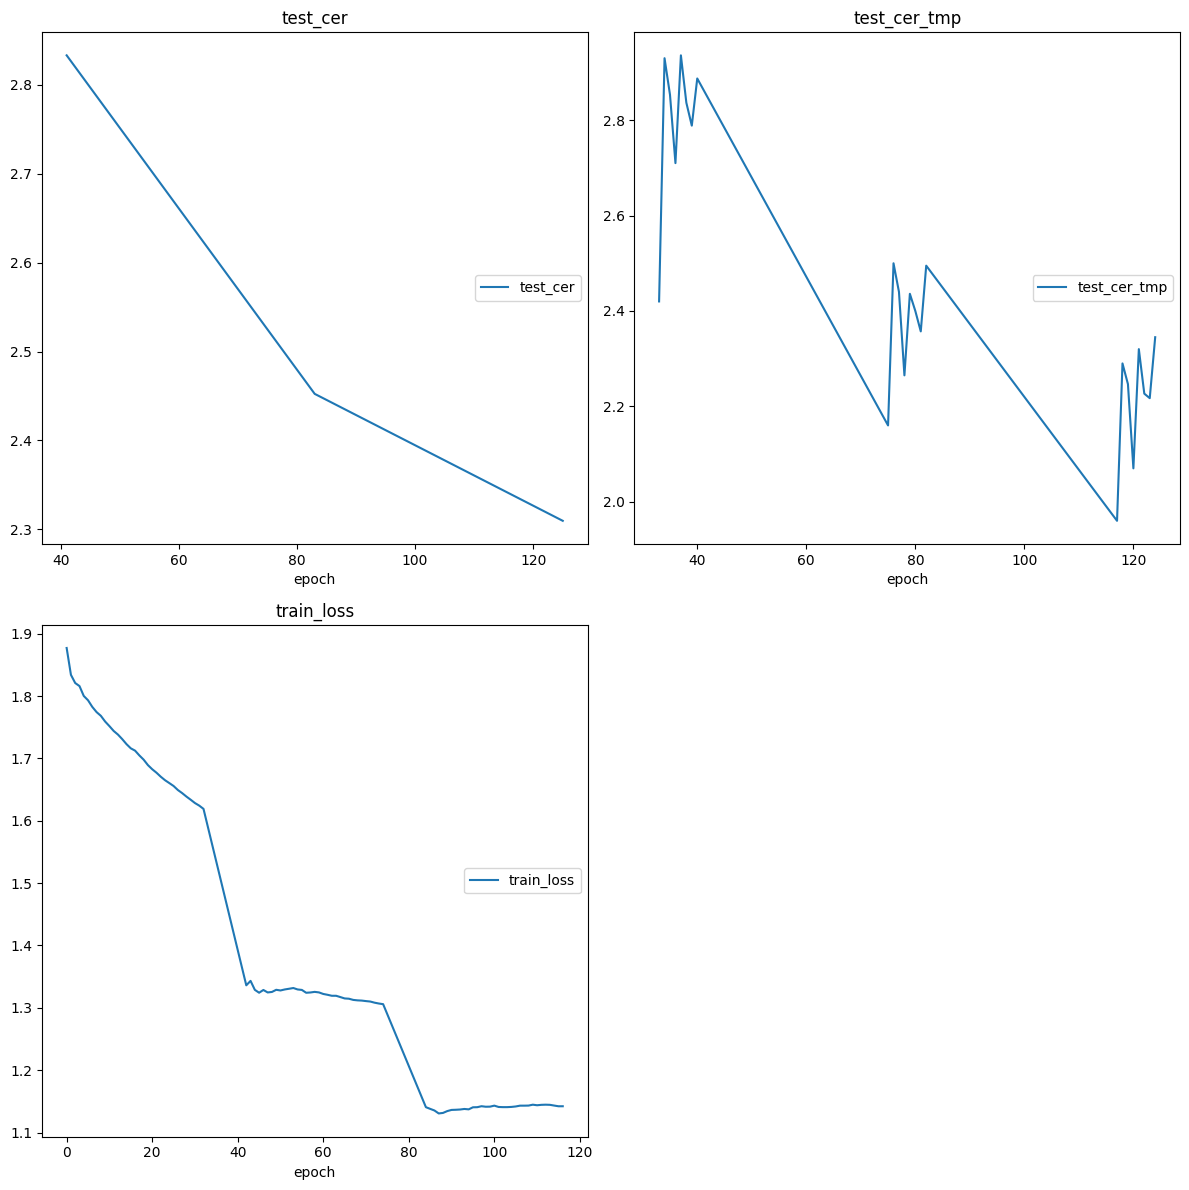

test_cer
	test_cer         	 (min:    2.310, max:    2.833, cur:    2.310)
test_cer_tmp
	test_cer_tmp     	 (min:    1.960, max:    2.936, cur:    2.345)
train_loss
	train_loss       	 (min:    1.131, max:    1.877, cur:    1.142)


In [50]:
criterion = ctc_loss(zero_infinity=True)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, amsgrad=True, weight_decay=1e-4)
plotlosses = PlotLosses()
min_cer = 10.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()

        input, labels = batch["image"].to(device), batch["seq"].long().to(device)
        preds = model(input).log_softmax(2)
        seq_lens_pred = torch.Tensor([preds.size(0)] * preds.size(1)).int()

        loss = criterion(preds, labels, seq_lens_pred, batch['seq_len'])
        loss.backward()
        optimizer.step()
        running_loss += loss.detach().cpu().item()

        if idx % 50 == 49:
            mean_loss = running_loss / (idx + 1)
            plotlosses.update({'train_loss': mean_loss})
            plotlosses.send()

    model.eval()
    running_cer = 0.0
    for idx, batch in enumerate(val_dataloader):
        input, text = batch["image"].to(device), batch["text"]
        preds = model(input).cpu().detach()
        texts_pred = decode(preds, alphabet)

        for pred, target in zip(texts_pred, text):
            cer = lev.distance(pred, target)
        running_cer += cer

        if idx % 50 == 49:
            mean_cer_tmp = running_cer / (idx + 1)
            plotlosses.update({'test_cer_tmp': mean_cer_tmp})
            plotlosses.send()

    mean_cer = running_cer / len(val_dataloader)
    if mean_cer < min_cer:
        torch.save(model.state_dict(), "/content/best_ocr2.pth")
        torch.save(model.state_dict(), "/content/drive/My Drive/best_ocr2.pth")
        min_cer = mean_cer
    plotlosses.update({'test_cer': mean_cer})
    plotlosses.send()


In [51]:
test_dataset = TestRecognitionDataset(transforms=Resize())
test_dataloader = DataLoader(test_dataset,
                              batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True,
                              drop_last=False, collate_fn=test_collate_fn)

res_texts = []
res_names = []
for idx, batch in enumerate(test_dataloader):
        optimizer.zero_grad()

        input, names = batch["image"], batch["name"]
        preds = model(input.to(device)).cpu().detach()
        texts_pred = decode(preds, alphabet)

        res_texts += texts_pred
        res_names += names


In [52]:
result_data = pd.DataFrame({'Id': res_names, 'Predicted': res_texts})
result_data['names_num'] = result_data['Id'].apply(lambda x: int(x[:-4]))
result_data = result_data.sort_values(by='names_num')
result_data

,Id,Predicted,names_num
40058,1.jpg,"рору,",1
45622,2.jpg,B,2
9769,3.jpg,LASANG ANG,3
10628,4.jpg,Mokelunns,4
36678,5.jpg,BAO,5
...,...,...,...
20072,52996.jpg,,52996
4691,52997.jpg,TUAN,52997
1685,52998.jpg,1505,52998
3403,52999.jpg,М,52999


In [53]:
result_data[['Id', 'Predicted']].to_csv('third_submission.csv', index = False)

In [54]:
result_data[['Id', 'Predicted']].to_csv('/content/drive/My Drive/third_submission.csv', index = False)